In [1]:
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input # 換模型請改這
from keras.layers import Flatten, Dense , Dropout
from keras import optimizers
from keras.models import Model 
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


# 模型網址
## 挑一個喜歡的去用吧,最強的不一定效果最好,因為不知道細節怎麼調也沒用,最好還是查一下其他人怎麼調參數
https://keras-contrib.readthedocs.io/en/latest/sources/applications/#inceptionresnetv2  

# 檢查路徑

In [2]:
root = "/data/examples/flower_classification/"
train_url = root + "train/"
test_csv = root + "submission.csv"
test_url = root + "test/"

In [3]:
os.listdir(train_url) 

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# 共用參數都在這

In [4]:
pic_size = 299
class_number = 5
free_layers = 2
epochs = 100
batch_size = 32
local_location = "//home/jovyan/my_data/kagle/cnn"  

In [5]:
map_dic = {}
mapping = pd.read_csv(root + "mapping.csv")
for index, row in mapping.iterrows():
    map_dic[row["dirs"]] = row["class"]

# 用dictionary保證不受順序影響1對1比對

In [6]:
map_dic

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

# 取類別與取圖片數量都經過洗牌,除以classnumber是保證每種類別都取相同的數量

In [7]:
def get_random_pic_location(batch_size): 
    batch_size = batch_size // class_number
    pic_dict = {}
    for pic_type in shuffle(os.listdir(train_url)):
        pic_type_number = map_dic[pic_type]
        pic_list = shuffle(os.listdir(train_url + pic_type))
        for pic in pic_list[:batch_size]:
            location = train_url + pic_type + "/" + pic
            pic_dict[location] = pic_type_number           
    return  [(k,v) for k,v in pic_dict.items()]       

# 手動切訓練與驗證集,然後再洗牌一次

In [8]:
def split_data(total_size, test_size):
    test_size = round(total_size * test_size)
    data = shuffle(get_random_pic_location(total_size))  
       
    test = data[:test_size]
    train = data[test_size:]   
    print(len(data), len(test))    
    return  train, test

In [9]:
train,test = split_data(3900, 0.2)

3547 780


# 切完檢查一下

In [10]:
train[:5]

[('/data/examples/flower_classification/train/rose/5001857501_f8b1e3e987_n.jpg',
  2),
 ('/data/examples/flower_classification/train/sunflower/8265023280_713f2c69d0_m.jpg',
  3),
 ('/data/examples/flower_classification/train/tulip/7094271655_79a6f972c1_n.jpg',
  4),
 ('/data/examples/flower_classification/train/dandelion/3530495617_fd84fb321a_m.jpg',
  1),
 ('/data/examples/flower_classification/train/dandelion/3761310831_41b5eba622_n.jpg',
  1)]

In [11]:
test[:5]

[('/data/examples/flower_classification/train/tulip/3637371174_a8dfcc1b35.jpg',
  4),
 ('/data/examples/flower_classification/train/daisy/5869147563_66fb88119d.jpg',
  0),
 ('/data/examples/flower_classification/train/daisy/5896679822_5f60d35c33_n.jpg',
  0),
 ('/data/examples/flower_classification/train/daisy/8694909523_3ca25d449d_n.jpg',
  0),
 ('/data/examples/flower_classification/train/rose/8960904651_9a0b727258.jpg',
  2)]

# 取圖優化版本,將數據操作移到迴圈之外,修正效能問題

In [12]:
# def get_batch_data_train(total_data, batch_size):    
#     total_data = shuffle(total_data)
#     data =  total_data[:batch_size]        
#     x_batch = []
#     y_batch = []    
#     for row in data:
#         loc = row[0]
#         num = row[1]        
#         y_batch.append(num)    
#         img = cv2.imread(loc)       
#         img = cv2.resize(img, (pic_size,pic_size))
#         x_batch.append(img)
    
#     x_batch = np.array(x_batch)
#     x_batch = x_batch.astype('float32')
#     x_batch /= 255   
#     return  x_batch , np.eye(class_number)[y_batch]

In [ ]:
def get_batch_data_train(total_data, batch_size):    
    total_data = shuffle(total_data)
    data =  total_data[:batch_size]        
    x_batch = []
    y_batch = []    
    for row in data:
        loc = row[0]
        num = row[1]        
        y_batch.append(num)    
        img = cv2.imread(loc)       
        img = cv2.resize(img, (pic_size,pic_size))
        x_batch.append(img)
    
    x_batch = np.array(x_batch)
    x_batch = x_batch.astype('float32')
#     x_batch /= 255   
    return  x_batch , np.eye(class_number)[y_batch]

In [13]:
x_train, y_train = get_batch_data_train(train, 3547)
print(x_train.shape, y_train.shape)

(2767, 299, 299, 3) (2767, 5)


In [14]:
x_test, y_test = get_batch_data_train(test, 780)
print(x_test.shape, y_test.shape)

(780, 299, 299, 3) (780, 5)


# 做之前看一下圖片吧,吃豬肉前看個豬走路不為過吧

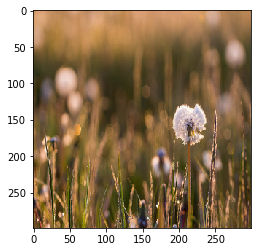

In [15]:
img = cv2.imread('/data/examples/flower_classification/train/dandelion/19613308325_a67792d889.jpg')
img = img[:,:,::-1] #轉回RGB
img = cv2.resize(img, (pic_size,pic_size))
plt.imshow(img)

# 模型存檔相關設定,會在你的資料夾生檔案,想開訓練去睡覺的可以放checkpoint移除earlystop,想快速交件就反過來

In [16]:
os.chdir(local_location)
save_dir = 'saved_models/'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, "keras3.h5")

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')

# 想用其他的模型直接換名字就好(換掉"InceptionResNetV2"),其他都不用改,Dropout可用可不用,freeze不會就別用,不然被問會GG

In [17]:
model = InceptionResNetV2(include_top=False,
                          weights='imagenet',
                          input_shape=(pic_size,pic_size,3))
added_layers = model.output
added_layers = Flatten()(added_layers)
# added_layers = Dropout(0.5)(added_layers)
output_layer = Dense(class_number, activation='softmax', name='softmax')(added_layers)

model_final = Model(inputs=model.input, outputs=output_layer)

model_final.compile(optimizer=optimizers.Adam(lr=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


# 想看模型細節可解開註解,幾百層的別用,會洗版

In [18]:
# print(model_final.summary())

# keras自帶的圖片增加器,切記如果你的圖片已經除了255,這邊不用在除255一次,不然會看到1X的LOSS...,然後他就死掉了

In [19]:
img_gen = ImageDataGenerator(
    horizontal_flip = True,
    fill_mode = "constant",
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3,
    rotation_range=30
)

In [20]:
model_history = model_final.fit_generator(img_gen.flow(x_train, y_train,
                                    batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(x_test, y_test),
                                    workers=4,  
                                    #callbacks=[earlystop]
                                    )

Epoch 1/100
87/87 [==============================] - 80s 915ms/step - loss: 1.3682 - acc: 0.4337 - val_loss: 0.8803 - val_acc: 0.7090
Epoch 2/100
87/87 [==============================] - 67s 765ms/step - loss: 0.8364 - acc: 0.6926 - val_loss: 0.5808 - val_acc: 0.8038
Epoch 3/100
87/87 [==============================] - 66s 764ms/step - loss: 0.6031 - acc: 0.7818 - val_loss: 0.4494 - val_acc: 0.8487
Epoch 4/100
87/87 [==============================] - 66s 764ms/step - loss: 0.4900 - acc: 0.8235 - val_loss: 0.3679 - val_acc: 0.8641
Epoch 5/100
87/87 [==============================] - 66s 764ms/step - loss: 0.4154 - acc: 0.8465 - val_loss: 0.3427 - val_acc: 0.8769
Epoch 6/100
87/87 [==============================] - 67s 766ms/step - loss: 0.3697 - acc: 0.8735 - val_loss: 0.3175 - val_acc: 0.8872
Epoch 7/100
87/87 [==============================] - 67s 766ms/step - loss: 0.3038 - acc: 0.8928 - val_loss: 0.2917 - val_acc: 0.9051
Epoch 8/100
87/87 [==============================] - 67s 766ms

# 都做完了,看一下圖吧

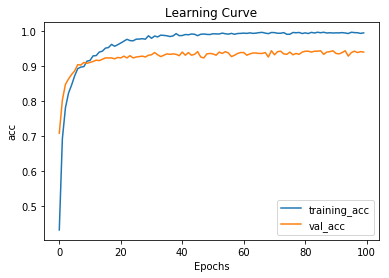

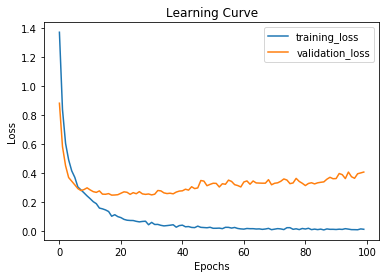

In [21]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

# 預測部分

In [ ]:
def get_batch_data_predict(total_data):  
    x_batch = []
    for index,row in total_data.iterrows():       
        url = test_url + row["id"] + ".jpg"
        img = cv2.imread(url)        
        img = cv2.resize(img, (pic_size,pic_size))
        x_batch.append(img)
    
    x_batch = np.array(x_batch)
    x_batch = x_batch.astype('float32')
    x_batch /= 255  
    
    return  x_batch 

# 用迴圈挑出每個陣列最大值的index

In [ ]:
def pick_max(list_data):    
    out = []
    for i in list_data:  
        out.append(np.argmax(i))
    return out    

In [ ]:
test_file = pd.read_csv(test_csv)

In [ ]:
test_file.head()

In [ ]:
data = get_batch_data_predict(test_file)

In [ ]:
predict = model_final.predict(data)

In [ ]:
result = pick_max(predict)

In [ ]:
result[:10]

# 確認沒問題可以交卷了

In [ ]:
pd.DataFrame({"id":test_file["id"],"class":result}).to_csv("mid2_4.csv", index=False)

# 手動存模型

In [ ]:
model_final.save("tf3.h5")